# ***MOVIE RATING PREDIDCTION***
Using the Dataset IMBs Movie India.csv from kaggle

In [ ]:
# Install
!pip install scikit-learn matplotlib seaborn joblib

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### 1. Loading the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('IMDb Movies India (1).csv', encoding='latin1')

print("Initial shape:", df.shape)
print(df.columns.tolist())
display(df.head())


Saving IMDb Movies India.csv to IMDb Movies India (1).csv
Initial shape: (15509, 10)
['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


### 2. Basic Cleaning & Target
1. Rename columns to safe names (strip)
2. Ensure Rating is numeric and drop rows with missing target





In [ ]:
df.columns = [c.strip() for c in df.columns] #1

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')#2
df = df.dropna(subset=['Rating'])
print("After dropping missing Rating:", df.shape)

After dropping missing Rating: (7919, 10)


### 3. Clean Year, Duration, Votes
1. Year: extract first 4-digit number
2. Duration: extract integer minutes
3. Votes: remove commas and convert

In [ ]:
# 1
def extract_year(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    m = re.search(r'(\d{4})', s)
    return int(m.group(1)) if m else np.nan

df['Year_clean'] = df['Year'].apply(extract_year)

# 2
def extract_duration(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else np.nan

if 'Duration' in df.columns:
    df['Duration_min'] = df['Duration'].apply(extract_duration)
else:
    df['Duration_min'] = np.nan

# 3
if 'Votes' in df.columns:
    df['Votes_clean'] = df['Votes'].astype(str).str.replace(',', '').replace('nan','',regex=False)
    df['Votes_clean'] = pd.to_numeric(df['Votes_clean'], errors='coerce')
else:
    df['Votes_clean'] = np.nan

### 4. Genre preprocessing (multi-label)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

def split_genre(x):
    if pd.isna(x):
        return []
    # Assume genres are comma-separated
    return [g.strip() for g in str(x).split(',') if g.strip()]

df['Genre_list'] = df['Genre'].apply(split_genre)
mlb = MultiLabelBinarizer(sparse_output=False)
genre_dummies = pd.DataFrame(mlb.fit_transform(df['Genre_list']),
                             columns=["genre__" + g for g in mlb.classes_],
                             index=df.index)

### 5. Director & Actors features (top-k)

In [ ]:
# Combine actors into a single field for text vectorization if needed
actor_cols = [c for c in df.columns if c.lower().startswith('actor')]
# Some datasets have "Actor 1", "Actor 2", ... using those columns:
actor_cols = [c for c in df.columns if 'Actor' in c or 'actor' in c or c.lower().startswith('actor')]
# fallback: check specific names present
possible_actor_cols = ['Actor 1', 'Actor 2', 'Actor 3', 'Actor1', 'Actor2', 'Actor3']
actor_cols = [c for c in possible_actor_cols if c in df.columns] or actor_cols

# Create a combined actors string
def combine_actors(row):
    parts = []
    for c in actor_cols:
        v = row.get(c)
        if pd.isna(v): continue
        parts.append(str(v).strip())
    return " | ".join(parts)

df['actors_combined'] = df.apply(combine_actors, axis=1)

# Director: keep top N directors as separate binary features, others as 'Other'
top_n_directors = 50
if 'Director' in df.columns:
    top_directors = df['Director'].fillna('Unknown').value_counts().nlargest(top_n_directors).index.tolist()
    df['Director_clean'] = df['Director'].fillna('Unknown').apply(lambda x: x if x in top_directors else 'Other')
else:
    df['Director_clean'] = 'Unknown'

# For actors, create top-M binary flags
top_m_actors = 80
actor_series = df['actors_combined'].str.split(r'\s*\|\s*').explode().dropna().str.strip()
top_actors = actor_series.value_counts().nlargest(top_m_actors).index.tolist()

for actor in top_actors:
    safe_col = "actor__" + re.sub(r'\W+', '_', actor)[:40]
    df[safe_col] = df['actors_combined'].apply(lambda s: 1 if pd.notna(s) and actor in s else 0)


### 6. Additional features

In [ ]:
# Movie title length
df['title_len'] = df['Name'].astype(str).apply(lambda s: len(s))

# Year age (how old the movie is relative to max year in dataset)
max_year = int(df['Year_clean'].max()) if df['Year_clean'].notna().any() else None
df['movie_age'] = df['Year_clean'].apply(lambda y: (max_year - y) if not pd.isna(y) and max_year is not None else np.nan)

### 7. Build final feature matrix

In [ ]:
# Numeric features
num_features = ['Year_clean', 'Duration_min', 'Votes_clean', 'title_len', 'movie_age']

# Director one-hot (top directors only)
dir_ohe = pd.get_dummies(df['Director_clean'], prefix='director')

# Actor binary columns already added above; collect them
actor_feature_cols = [c for c in df.columns if c.startswith('actor__')]

# Combine everything
X = pd.concat([
    df[num_features],
    genre_dummies,
    dir_ohe,
    df[actor_feature_cols]
], axis=1)

# Fill any missing numeric features with median
X[num_features] = X[num_features].fillna(X[num_features].median())

# Target
y = df['Rating'].astype(float)

print("Feature matrix shape:", X.shape)
display(X.head())

Feature matrix shape: (7919, 158)


,Year_clean,Duration_min,Votes_clean,title_len,movie_age,genre__Action,genre__Adventure,genre__Animation,genre__Biography,genre__Comedy,...,actor__Mehmood,actor__Tabu,actor__Moushumi_Chatterjee,actor__Asha_Parekh,actor__Jimmy_Sheirgill,actor__Amrish_Puri,actor__Rakesh_Bedi,actor__Danny_Denzongpa,actor__Madhubala,actor__Smita_Patil
1,2019,109.0,8,34,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019,110.0,35,7,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1997,147.0,827,20,24,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,2005,142.0,1086,9,16,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,2012,82.0,326,18,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 8. Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (6335, 158) Test shape: (1584, 158)


### 9. Models: Linear Regression and RandomForest

In [ ]:
# Simple baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest (tune n_estimators quickly)
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### 10. Evaluation function

In [ ]:
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

res_lr = evaluate(y_test, y_pred_lr, "LinearRegression")
res_rf = evaluate(y_test, y_pred_rf, "RandomForest")

--- LinearRegression ---
MAE: 0.9376
MSE: 1.4381
RMSE: 1.1992
R2: 0.2265
--- RandomForest ---
MAE: 0.8113
MSE: 1.1704
RMSE: 1.0818
R2: 0.3705


### 11. Plots: Actual vs Predicted & Residuals

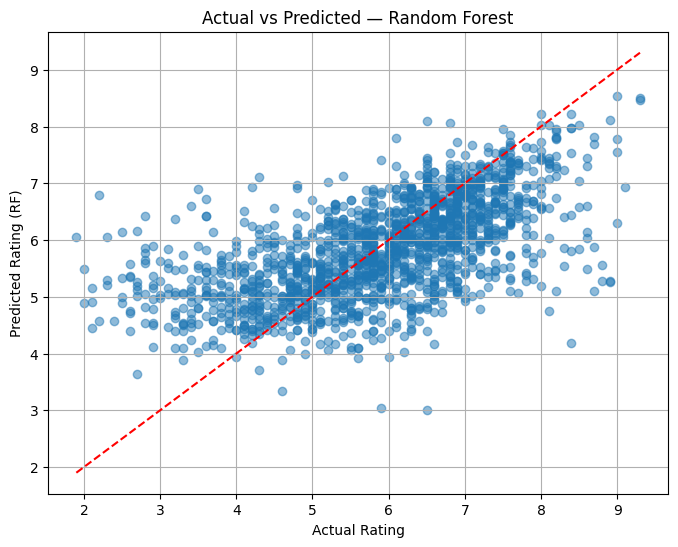

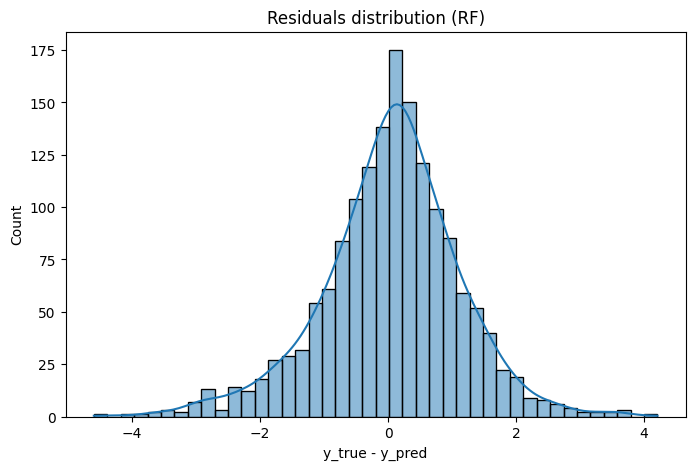

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating (RF)")
plt.title("Actual vs Predicted — Random Forest")
plt.grid(True)
plt.show()

residuals = y_test - y_pred_rf
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution (RF)")
plt.xlabel("y_true - y_pred")
plt.show()

### 12. Feature importance (top 30)

Top 30 important features (RF):


,0
Votes_clean,0.251497
movie_age,0.117747
Year_clean,0.110497
Duration_min,0.110051
title_len,0.095181
genre__Documentary,0.037960
genre__Action,0.022994
genre__Drama,0.021916
genre__Romance,0.016961
genre__Horror,0.016760


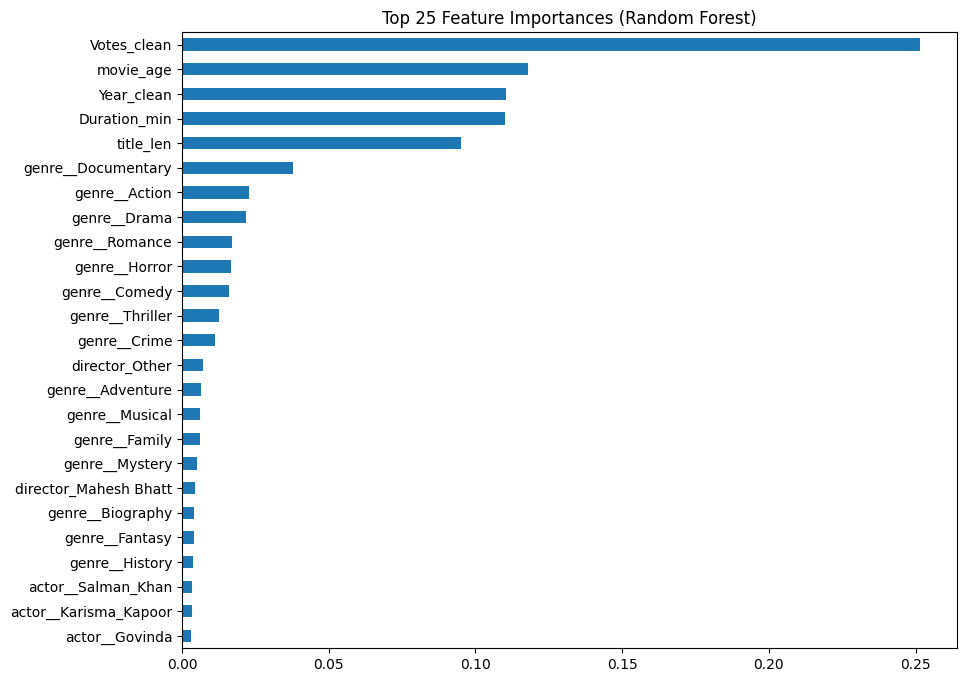

In [ ]:
importances = rf.feature_importances_
feature_names = X.columns.to_list()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top 30 important features (RF):")
display(feat_imp.head(30))

plt.figure(figsize=(10,8))
feat_imp.head(25).sort_values().plot(kind='barh')
plt.title("Top 25 Feature Importances (Random Forest)")
plt.show()

### 13. Example prediction (new sample)

In [ ]:
def make_feature_vector(sample_dict, features_list):
    # sample_dict keys: Name, Year, Duration, Genre, Votes, Director, Actor 1..3
    # Create empty vector
    vec = pd.Series(0, index=features_list, dtype=float)
    # numeric:
    vec['Year_clean'] = extract_year(sample_dict.get('Year', np.nan)) or np.nan
    vec['Duration_min'] = extract_duration(sample_dict.get('Duration', np.nan)) or np.nan
    votes_val = sample_dict.get('Votes', np.nan)
    if pd.notna(votes_val):
        try:
            vec['Votes_clean'] = float(str(votes_val).replace(',',''))
        except:
            vec['Votes_clean'] = np.nan
    # title length
    vec['title_len'] = len(str(sample_dict.get('Name','')))
    # movie_age
    vec['movie_age'] = (max_year - vec['Year_clean']) if (not pd.isna(vec['Year_clean']) and max_year is not None) else np.nan

    # genres
    genres = split_genre(sample_dict.get('Genre',''))
    for g in genres:
        col = "genre__" + g
        if col in vec.index:
            vec[col] = 1

    # director
    director = sample_dict.get('Director', 'Unknown')
    director_clean = director if director in top_directors else 'Other'
    col_dir = 'director_' + director_clean
    if col_dir in vec.index:
        vec[col_dir] = 1

    # actors
    actors_text = " | ".join([str(sample_dict.get(k,'')) for k in ['Actor 1','Actor 2','Actor 3'] if sample_dict.get(k)])
    for actor in top_actors:
        safe_col = "actor__" + re.sub(r'\W+', '_', actor)[:40]
        if safe_col in vec.index and actor in actors_text:
            vec[safe_col] = 1

    # Fill numeric medians from training
    vec[num_features] = vec[num_features].fillna(X[num_features].median())
    return vec

sample = {
    'Name': "Sample Movie",
    'Year': "(2021)",
    'Duration': "120 min",
    'Genre': "Drama, Romance",
    'Votes': "1,234",
    'Director': "Some Director",
    'Actor 1': "Top Actor Name",  # if matches top actors will set flag
    'Actor 2': "",
    'Actor 3': ""
}

fv = make_feature_vector(sample, X.columns.tolist())
pred_sample = rf.predict(fv.values.reshape(1, -1))[0]
print("Predicted rating for sample:", pred_sample)


Predicted rating for sample: 6.3319999999999945


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### 14.  Quick summary metrics DataFrame

In [ ]:
metrics_df = pd.DataFrame([res_lr, res_rf], index=['LinearRegression','RandomForest'])
display(metrics_df)

print("Pipeline finished.")

,mae,mse,rmse,r2
LinearRegression,0.937642,1.43809,1.199204,0.226478
RandomForest,0.811272,1.17037,1.081836,0.370480


Pipeline finished.
